In [1]:
# from poclaps import environments

# game, params = environments.make('SimpleGridWorld-v0')

In [2]:
# import jax
# key = jax.random.PRNGKey(1)
# obs, state = game.reset(key, params)
# print(game.to_string(state, params))

In [3]:
# key = jax.random.PRNGKey(0)
# from poclaps.simple_gridworld_game import GridAction
# next_obs, next_state, reward, done, info = game.step_env(key, state, GridAction.UP, params)
# print(game.to_string(next_state, params))

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def print_grid(grid_size: int, symbols_on_grid: dict):
    print("-" * (grid_size * 4 + 1))
    for y in range(grid_size):
        print("|", end="")
        for x in range(grid_size):
            symbol = symbols_on_grid.get((x, y), " ")
            print(f" {symbol} |", end="")
        print("\n" + "-" * (grid_size * 4 + 1))

In [6]:
class GridWorldGame:

    def __init__(self, grid_size: int):
        self.grid_size = grid_size
        self.goal_pos = None
        self.agent_pos = None

    def reset(self):
        self.goal_pos = np.random.randint(0, self.grid_size, size=2)
        self.agent_pos = np.random.randint(0, self.grid_size, size=2)

    def step(self, action: int):
        if action == 0:
            self.agent_pos[0] = np.clip(self.agent_pos[0] - 1, 0, self.grid_size - 1)
        elif action == 1:
            self.agent_pos[0] = np.clip(self.agent_pos[0] + 1, 0, self.grid_size - 1)
        elif action == 2:
            self.agent_pos[1] = np.clip(self.agent_pos[1] - 1, 0, self.grid_size - 1)
        elif action == 3:
            self.agent_pos[1] = np.clip(self.agent_pos[1] + 1, 0, self.grid_size - 1)

        reward = 0
        done = np.all(self.agent_pos == self.goal_pos)

        if done:
            reward = 1
        elif np.any(self.agent_pos < 0) or np.any(self.agent_pos >= self.grid_size):
            reward = -1

        return reward, done

    def print(self):
        symbols_on_grid = {
            tuple(self.goal_pos): "G",
            tuple(self.agent_pos): "A"
        }
        print_grid(self.grid_size, symbols_on_grid)

In [7]:
def optimal_policy_1(game) -> int:
    """ Implements an optimal-policy for the game """
    if game.agent_pos[0] < game.goal_pos[0]:
        return 1
    elif game.agent_pos[0] > game.goal_pos[0]:
        return 0
    elif game.agent_pos[1] < game.goal_pos[1]:
        return 3
    elif game.agent_pos[1] > game.goal_pos[1]:
        return 2

def optimal_policy_2(game) -> int:
    """ Implements an optimal-policy for the game """
    if game.agent_pos[1] < game.goal_pos[1]:
        return 3
    elif game.agent_pos[1] > game.goal_pos[1]:
        return 2
    elif game.agent_pos[0] < game.goal_pos[0]:
        return 1
    elif game.agent_pos[0] > game.goal_pos[0]:
        return 0

import random

def stochastic_optimal_policy(game, seed: int) -> int:
    random.seed(hash((seed, *game.agent_pos, *game.goal_pos)))
    if random.random() < 0.5:
        return optimal_policy_1(game)
    else:
        return optimal_policy_2(game)

In [8]:
game = GridWorldGame(4)
game.reset()
game.print()
done = False
while not done:
    action = optimal_policy_1(game)
    print(f"Taking action {action}")
    reward, done = game.step(action)
    print(f"Reward: {reward}, Done: {done}")
    game.print()


-----------------
|   |   |   |   |
-----------------
|   |   |   |   |
-----------------
|   |   | G | A |
-----------------
|   |   |   |   |
-----------------
Taking action 0
Reward: 1, Done: True
-----------------
|   |   |   |   |
-----------------
|   |   |   |   |
-----------------
|   |   | A |   |
-----------------
|   |   |   |   |
-----------------


In [9]:
action_arrow_symbols = ["←", "→", "↑", "↓"]


def visualise_policy(game: GridWorldGame, policy: callable):
    actions_taken = {
        tuple(game.goal_pos): "G"
    }

    for x in range(game.grid_size):
        for y in range(game.grid_size):
            if x == game.goal_pos[0] and y == game.goal_pos[1]:
                continue
            game.agent_pos = np.array([x, y])
            action = policy(game)
            actions_taken[(x, y)] = action_arrow_symbols[action]

    print_grid(game.grid_size, actions_taken)

### Visualising Optimal Policies

In this game, consider two optimal policies. One in which the player prioritises moving along the x-axis, and another in which the player prioritises moving along the y-axis.

In [10]:
game = GridWorldGame(5)
game.reset()
game.goal_pos = np.array([2, 2])
visualise_policy(game, optimal_policy_1)

---------------------
| → | → | ↓ | ← | ← |
---------------------
| → | → | ↓ | ← | ← |
---------------------
| → | → | G | ← | ← |
---------------------
| → | → | ↑ | ← | ← |
---------------------
| → | → | ↑ | ← | ← |
---------------------


In [11]:
visualise_policy(game, optimal_policy_2)

---------------------
| ↓ | ↓ | ↓ | ↓ | ↓ |
---------------------
| ↓ | ↓ | ↓ | ↓ | ↓ |
---------------------
| → | → | G | ← | ← |
---------------------
| ↑ | ↑ | ↑ | ↑ | ↑ |
---------------------
| ↑ | ↑ | ↑ | ↑ | ↑ |
---------------------


In [12]:
from functools import partial

visualise_policy(game, partial(stochastic_optimal_policy, seed=0))
visualise_policy(game, partial(stochastic_optimal_policy, seed=1))
visualise_policy(game, partial(stochastic_optimal_policy, seed=2))

---------------------
| → | → | ↓ | ↓ | ← |
---------------------
| → | ↓ | ↓ | ↓ | ↓ |
---------------------
| → | → | G | ← | ← |
---------------------
| ↑ | → | ↑ | ↑ | ← |
---------------------
| → | ↑ | ↑ | ← | ← |
---------------------
---------------------
| → | ↓ | ↓ | ↓ | ← |
---------------------
| ↓ | ↓ | ↓ | ↓ | ← |
---------------------
| → | → | G | ← | ← |
---------------------
| → | ↑ | ↑ | ← | ← |
---------------------
| ↑ | → | ↑ | ← | ← |
---------------------
---------------------
| → | ↓ | ↓ | ← | ← |
---------------------
| → | ↓ | ↓ | ← | ← |
---------------------
| → | → | G | ← | ← |
---------------------
| ↑ | ↑ | ↑ | ↑ | ↑ |
---------------------
| → | ↑ | ↑ | ← | ↑ |
---------------------


In [13]:
from itertools import product


def policy_executes_actions(game: GridWorldGame,
                            policy: callable,
                            actions: int | list):
    actions = actions if isinstance(actions, list) else [actions]
    for a in actions:
        if isinstance(a, str):
            a = action_arrow_symbols.index(a)
        if policy(game) != a:
            return False
        game.step(a)
    return True


def get_possible_goal_locations(game: GridWorldGame, actions: int | list, policy: callable):
    actions = actions if isinstance(actions, list) else [actions]
    if isinstance(actions[0], list):
        return set.intersection(*[set(get_possible_goal_locations(game, a, policy)) for a in actions])

    goal_locations = []
    for agent_pos in product(range(game.grid_size), repeat=2):
        for goal_pos in product(range(game.grid_size), repeat=2):
            game.agent_pos = np.array(agent_pos)
            game.goal_pos = np.array(goal_pos)
            if policy_executes_actions(game, policy, actions):
                goal_locations.append(goal_pos)

    return goal_locations

In [14]:
def generate_poclap_sample(policy, grid_size: int = 5, seed: int = 0):
    game = GridWorldGame(grid_size)
    np.random.seed(seed)
    game.reset()
    agent_pos = [game.agent_pos.copy()]
    actions = []
    goal_pos = game.goal_pos.copy()
    done = False
    while not done:
        action = policy(game)
        actions.append(action)
        _, done = game.step(action)
        if not done:
            agent_pos.append(game.agent_pos.copy())
    
    return {
        'agent_positions': agent_pos,
        'actions': actions,
        'goal_position': goal_pos
    }


generate_poclap_sample(optimal_policy_1, seed=1)

{'agent_positions': [array([0, 1]),
  array([1, 1]),
  array([2, 1]),
  array([3, 1]),
  array([3, 2]),
  array([3, 3])],
 'actions': [1, 1, 1, 3, 3, 3],
 'goal_position': array([3, 4])}

In [15]:
generate_poclap_sample(optimal_policy_2, seed=1)

{'agent_positions': [array([0, 1]),
  array([0, 2]),
  array([0, 3]),
  array([0, 4]),
  array([1, 4]),
  array([2, 4])],
 'actions': [3, 3, 3, 1, 1, 1],
 'goal_position': array([3, 4])}

In [16]:
poclap_sample = generate_poclap_sample(partial(stochastic_optimal_policy, seed=0), seed=1)

In [17]:
poclap_sample = generate_poclap_sample(optimal_policy_1, seed=1)
possible_goals = get_possible_goal_locations(
    game, poclap_sample['actions'], optimal_policy_1
)
possible_goals

[(3, 3), (3, 4), (3, 4), (4, 3), (4, 4), (4, 4)]

In [18]:
poclap_sample = generate_poclap_sample(optimal_policy_1, seed=1)
possible_goals = get_possible_goal_locations(
    game, poclap_sample['actions'], optimal_policy_2
)
possible_goals

[]

In [19]:
poclap_sample = generate_poclap_sample(optimal_policy_1, seed=1)
possible_goals = set()
for seed in range(1000):
    possible_goals_seed = get_possible_goal_locations(
        game, poclap_sample['actions'], partial(stochastic_optimal_policy, seed=seed)
    )
    possible_goals = set(possible_goals_seed) | possible_goals

poclap_sample['goal_position'], possible_goals

(array([3, 4]), {(3, 3), (3, 4), (4, 3), (4, 4)})

In [20]:
actions_seqs = [
    ['→', '→', '↑'],
    ['↑', '↑', '↑'],
    ['→', '→','→', '↑', '↑'],
    ['←', '↓'],
]

In [21]:
for action_seq in actions_seqs:
    seq_str = ' '.join(action_seq)
    print('Action Sequence:', seq_str)
    possible_goals = get_possible_goal_locations(
        game, action_seq, optimal_policy_1
    )
    print('Goal locations consistent with sequence:')
    print_grid(game.grid_size, {
        pos: 'X' for pos in possible_goals
    })
    print()

possible_goals = get_possible_goal_locations(game, actions_seqs, optimal_policy_1)
print('Goal locations consistent with all sequences:')
print_grid(game.grid_size, {
    pos: 'X' for pos in possible_goals
})

Action Sequence: → → ↑
Goal locations consistent with sequence:
---------------------
|   |   | X | X | X |
---------------------
|   |   | X | X | X |
---------------------
|   |   | X | X | X |
---------------------
|   |   | X | X | X |
---------------------
|   |   |   |   |   |
---------------------

Action Sequence: ↑ ↑ ↑
Goal locations consistent with sequence:
---------------------
| X | X | X | X | X |
---------------------
| X | X | X | X | X |
---------------------
|   |   |   |   |   |
---------------------
|   |   |   |   |   |
---------------------
|   |   |   |   |   |
---------------------

Action Sequence: → → → ↑ ↑
Goal locations consistent with sequence:
---------------------
|   |   |   | X | X |
---------------------
|   |   |   | X | X |
---------------------
|   |   |   | X | X |
---------------------
|   |   |   |   |   |
---------------------
|   |   |   |   |   |
---------------------

Action Sequence: ← ↓
Goal locations consistent with sequence:
-------------

In [22]:
def information_gain(grid_size, n_possibilities):
    if n_possibilities == 0:
        return 0
    return np.log2(grid_size * grid_size) - np.log2(n_possibilities)

In [23]:
information_gain(game.grid_size, 1)

4.643856189774724

In [32]:
action_seq_samples = []

game.reset()
TRUE_GOAL_POS = np.array([2, 2])
game.goal_pos = TRUE_GOAL_POS.copy()


def rollout_policy(game: GridWorldGame, policy: callable):
    actions = []
    done = False
    while not done:
        action = policy(game)
        if action is None:
            break
        actions.append(action)
        _, done = game.step(action)
    return actions


for x, y in product(range(game.grid_size), repeat=2):
    game.agent_pos = np.array([x, y])
    actions = rollout_policy(game, optimal_policy_1)
    if actions:
        action_seq_samples.append(actions)

In [25]:
action_seq_samples

[[1, 1, 3, 3],
 [1, 1, 3],
 [1, 1],
 [1, 1, 2],
 [1, 1, 2, 2],
 [1, 3, 3],
 [1, 3],
 [1],
 [1, 2],
 [1, 2, 2],
 [3, 3],
 [3],
 [2],
 [2, 2],
 [0, 3, 3],
 [0, 3],
 [0],
 [0, 2],
 [0, 2, 2],
 [0, 0, 3, 3],
 [0, 0, 3],
 [0, 0],
 [0, 0, 2],
 [0, 0, 2, 2]]

In [26]:
import random
from tqdm import tqdm

sample_trials = 25
items = []

k_total = 25

random.seed(0)

prog_bar = tqdm(total=k_total)

for k in range(1, k_total):
    for _ in range(sample_trials):
        data_sample = random.sample(action_seq_samples, k)
        possible_goals = get_possible_goal_locations(game, data_sample, optimal_policy_1)
        gain = information_gain(game.grid_size, len(possible_goals))
        items.append({
            'k': k,
            'gain': gain
        })
    prog_bar.update()

df = pd.DataFrame(items)

  4%|▍         | 1/25 [00:00<00:03,  7.71it/s]

 96%|█████████▌| 24/25 [00:38<00:02,  2.77s/it]

In [27]:
import random
from tqdm import tqdm

sample_trials = 25
items = []

k_total = 25

random.seed(0)

prog_bar = tqdm(total=k_total)

for k in range(1, k_total):
    for _ in range(sample_trials):
        data_sample = random.sample(action_seq_samples, k)
        possible_goals = get_possible_goal_locations(game, data_sample, optimal_policy_2)
        gain = information_gain(game.grid_size, len(possible_goals))
        items.append({
            'k': k,
            'gain': gain
        })
    prog_bar.update()

wrong_policy_df = pd.DataFrame(items)

 96%|█████████▌| 24/25 [00:38<00:01,  1.61s/it]


In [44]:
import random
from tqdm import tqdm

sample_trials = 10
policy_samples = 25
items = []

k_total = 25

random.seed(0)

prog_bar = tqdm(total=k_total)

for k in range(1, k_total):
    for sample_seed in range(sample_trials):
        random.seed(sample_seed)
        data_sample = random.sample(action_seq_samples, k)
        possible_goals = set()
        for policy_seed in range(policy_samples):
            policy_possible_goals = get_possible_goal_locations(
                game, data_sample, partial(stochastic_optimal_policy, seed=policy_seed)
            )
            possible_goals = set(policy_possible_goals) | possible_goals
            gain = information_gain(game.grid_size, len(possible_goals))
            items.append({
                'k': k,
                'gain': gain,
                'policy_samples': policy_seed,
                'true_goal_in_possible': tuple(TRUE_GOAL_POS) in possible_goals
            })

    prog_bar.update()

stochastic_policy_df = pd.DataFrame(items)

  0%|          | 0/25 [02:02<?, ?it/s]


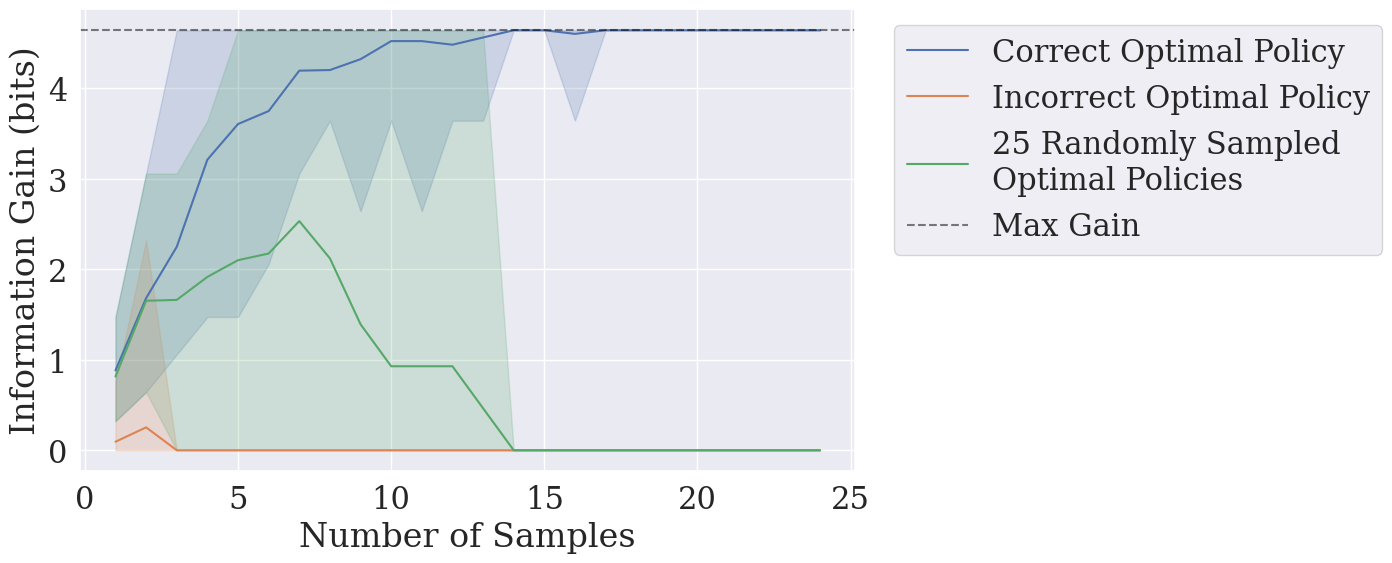

reformatted figures/information_gain_vs_samples_diff_policies/code.py

All done! ✨ 🍰 ✨
1 file reformatted.


In [29]:
def plot_information_gain(df: pd.DataFrame, wrong_policy_df, stochastic_policy_df, max_gain: float):
    set_plotting_style(font_scale=2)
    plt.figure(figsize=(10, 6))
    ax = sns.lineplot(data=df, x='k', y='gain', errorbar=lambda x: (x.min(), x.max()), label='Correct Optimal Policy')
    sns.lineplot(data=wrong_policy_df, x='k', y='gain', ax=ax, errorbar=lambda x: (x.min(), x.max()), label='Incorrect Optimal Policy')
    max_policy_samples = stochastic_policy_df.policy_samples.max()
    sns.lineplot(data=stochastic_policy_df[stochastic_policy_df.policy_samples == max_policy_samples],
                 x='k', y='gain', ax=ax, errorbar=lambda x: (x.min(), x.max()),
                 label=f'{max_policy_samples+1} Randomly Sampled\nOptimal Policies')
    ax.axhline(max_gain, color='black', linestyle='--', label='Max Gain', alpha=0.5)
    ax.set_xlabel('Number of Samples')
    ax.set_ylabel('Information Gain (bits)')
    ax.legend(loc='upper right', bbox_to_anchor=(1.7, 1))


from reproducible_figures import save_reproducible_figure, set_plotting_style

save_reproducible_figure(
    'information_gain_vs_samples_diff_policies',
    (df, wrong_policy_df, stochastic_policy_df),
    plot_information_gain,
    show=True,
    max_gain=information_gain(game.grid_size, 1)
)

In [30]:
heatmap = (stochastic_policy_df\
    .groupby(['k', 'policy_samples']).gain.mean()\
    .reset_index()\
    .pivot(index='k', columns='policy_samples', values='gain')
)

<Axes: xlabel='policy_samples', ylabel='k'>

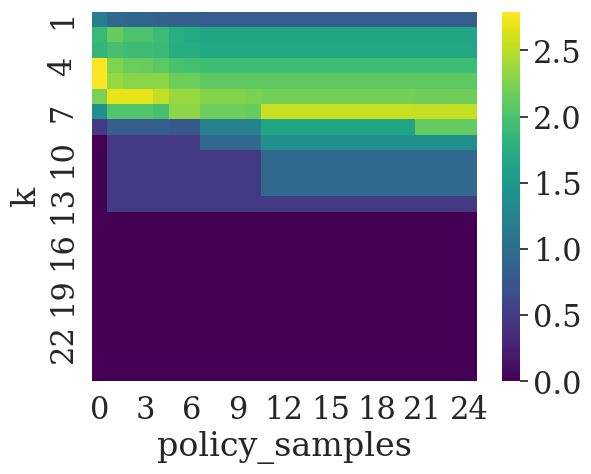

In [31]:
sns.heatmap(heatmap, cmap='viridis', square=True)

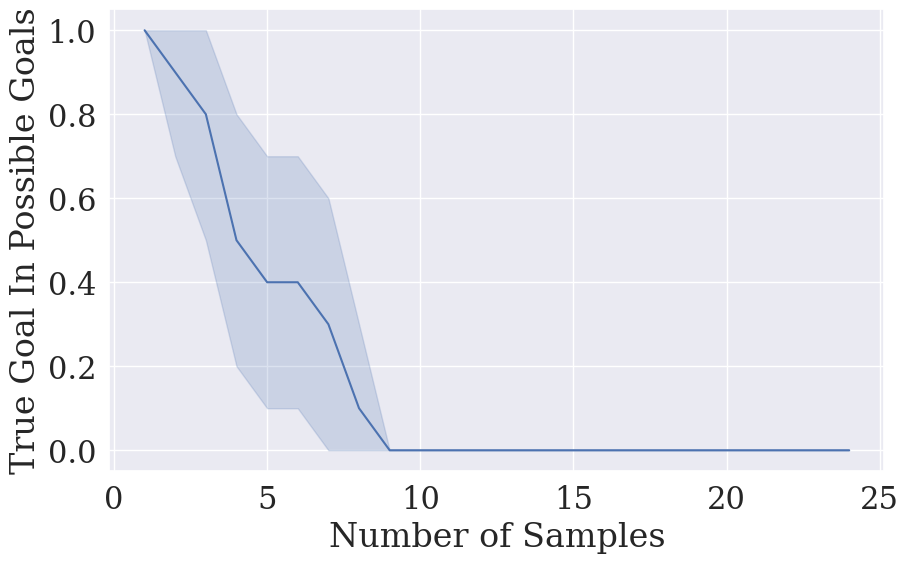

reformatted figures/true_goal_rate_vs_samples/code.py

All done! ✨ 🍰 ✨
1 file reformatted.


In [49]:
def plot_true_goal_rate(stochastic_policy_df):
    set_plotting_style(font_scale=2)
    plt.figure(figsize=(10, 6))
    max_policy_samples = stochastic_policy_df.policy_samples.max()
    ax = sns.lineplot(
        data=stochastic_policy_df[stochastic_policy_df.policy_samples == max_policy_samples],
        x='k', y='true_goal_in_possible'
    )
    ax.set_xlabel('Number of Samples')
    ax.set_ylabel('True Goal In Possible Goals')


save_reproducible_figure(
    'true_goal_rate_vs_samples',
    stochastic_policy_df,
    plot_true_goal_rate,
    show=True
)